In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from starfish.set import settings

In [3]:
DESI=[]
for redshift in settings.z:
    df=pd.DataFrame(np.loadtxt(f'data/QSO/DESI_{redshift:.1f}.csv',delimiter=','),index=settings.var_name,columns=settings.var_name)
    df=df.drop('N_eff',axis=0)
    df=df.drop('N_eff',axis=1)
    DESI.append(df)

In [4]:
DESI_valid=[]
for fisher in DESI:
    fisher_valid=fisher.copy()
    for index in fisher_valid.index:
        if (fisher_valid.loc[index,:]==0).all():
            fisher_valid=fisher_valid.drop(index,axis=0)
            fisher_valid=fisher_valid.drop(index,axis=1)
    cov=pd.DataFrame(np.linalg.inv(fisher_valid.values),index=fisher_valid.index,columns=fisher_valid.columns)
    DESI_valid.append(cov.iloc[:settings.cosmo_num,:settings.cosmo_num])

In [5]:
from getdist import plots
from getdist.gaussian_mixtures import GaussianND

gauss = []
for c in DESI_valid:
    g = GaussianND(settings.cosmo_value, c, is_inv_cov=False, names=settings.var_exp)
    g.paramNames.names[-3].name = r"$\sum m_\nu\;[\mathrm{eV}]$"
    g.paramNames.names[-3].label = ""
    g.names = settings.var_exp
    gauss.append(g)

In [6]:
import seaborn as sns
palette=sns.color_palette('rocket_r',n_colors=len(DESI_valid))
palette

[(0.96516917, 0.70776351, 0.5606593),
 (0.95381595, 0.46373781, 0.31769923),
 (0.8833417, 0.19830556, 0.26014181),
 (0.67824099, 0.09192342, 0.3504148),
 (0.43860848, 0.12177004, 0.34119475),
 (0.20973515, 0.09747934, 0.24238489)]

In [8]:
orders=[r'$h$',r'$\Omega_\mathrm{m,0}$',r'$\Omega_\mathrm{b,0}$',r'$\sigma_8$',r'$n_\mathrm{s}$',r'$\sum m_\nu\;[\mathrm{eV}]$',r'$w_0$',r'$w_a$']
m=dict(zip(settings.var_exp,settings.cosmo_value))
err=[]
for c in DESI_valid:
    err.append(np.sqrt(np.diag(c)))
err_max=np.sort(np.stack(err,axis=0),axis=0)[-1,:]
limits=list(zip(settings.cosmo_value-2*err_max,settings.cosmo_value+2*err_max))
d=dict(zip(settings.var_exp,limits))

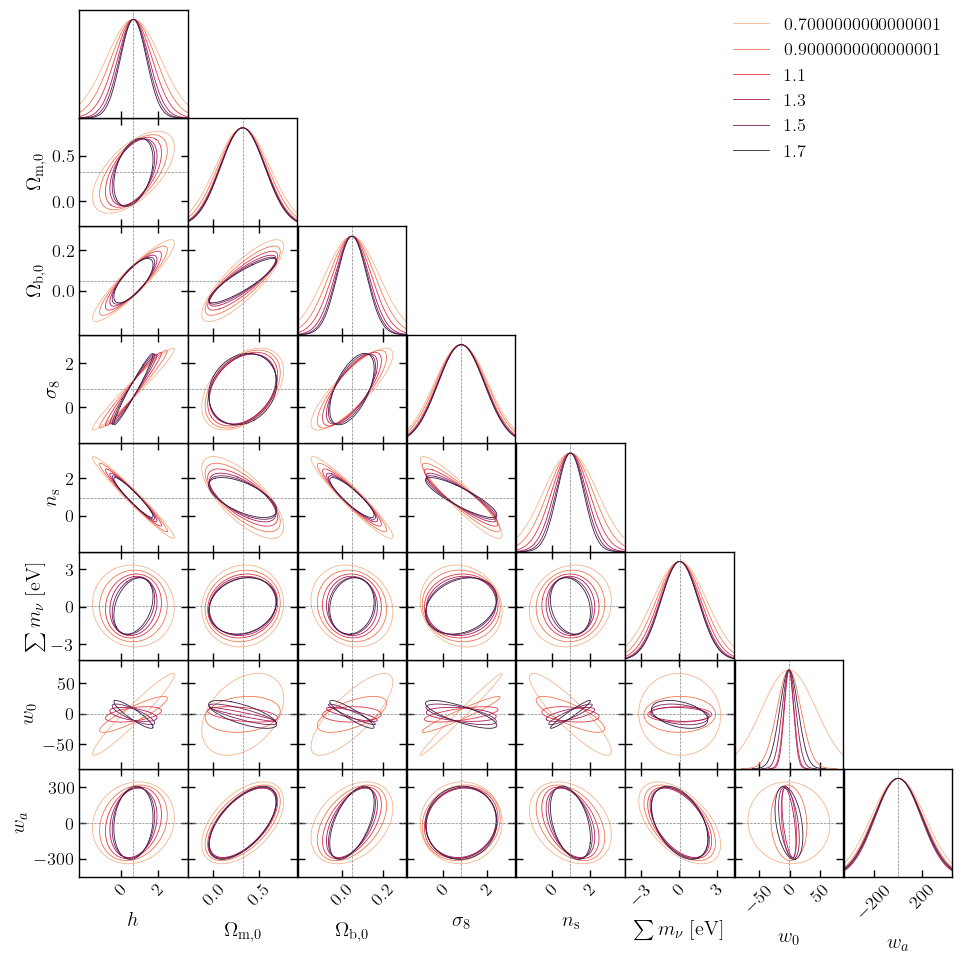

In [9]:
sns.set_context('paper',font_scale=2)
ploter=plots.get_subplot_plotter(width_inch=10,rc_sizes=True)
ploter.settings.tight_layout=True
ploter.settings.axis_tick_x_rotation=45
ploter.settings.figure_legend_frame=False
ploter.settings.num_plot_contours=1
ploter.triangle_plot(
    gauss,
    params=orders,
    param_limits=d,
    filled=False,
    markers=m,
    marker_args={'color':'gray'},
    legend_labels=settings.z,
    contour_colors=palette,
    contour_ls='-',
    legend_loc='upper right',)

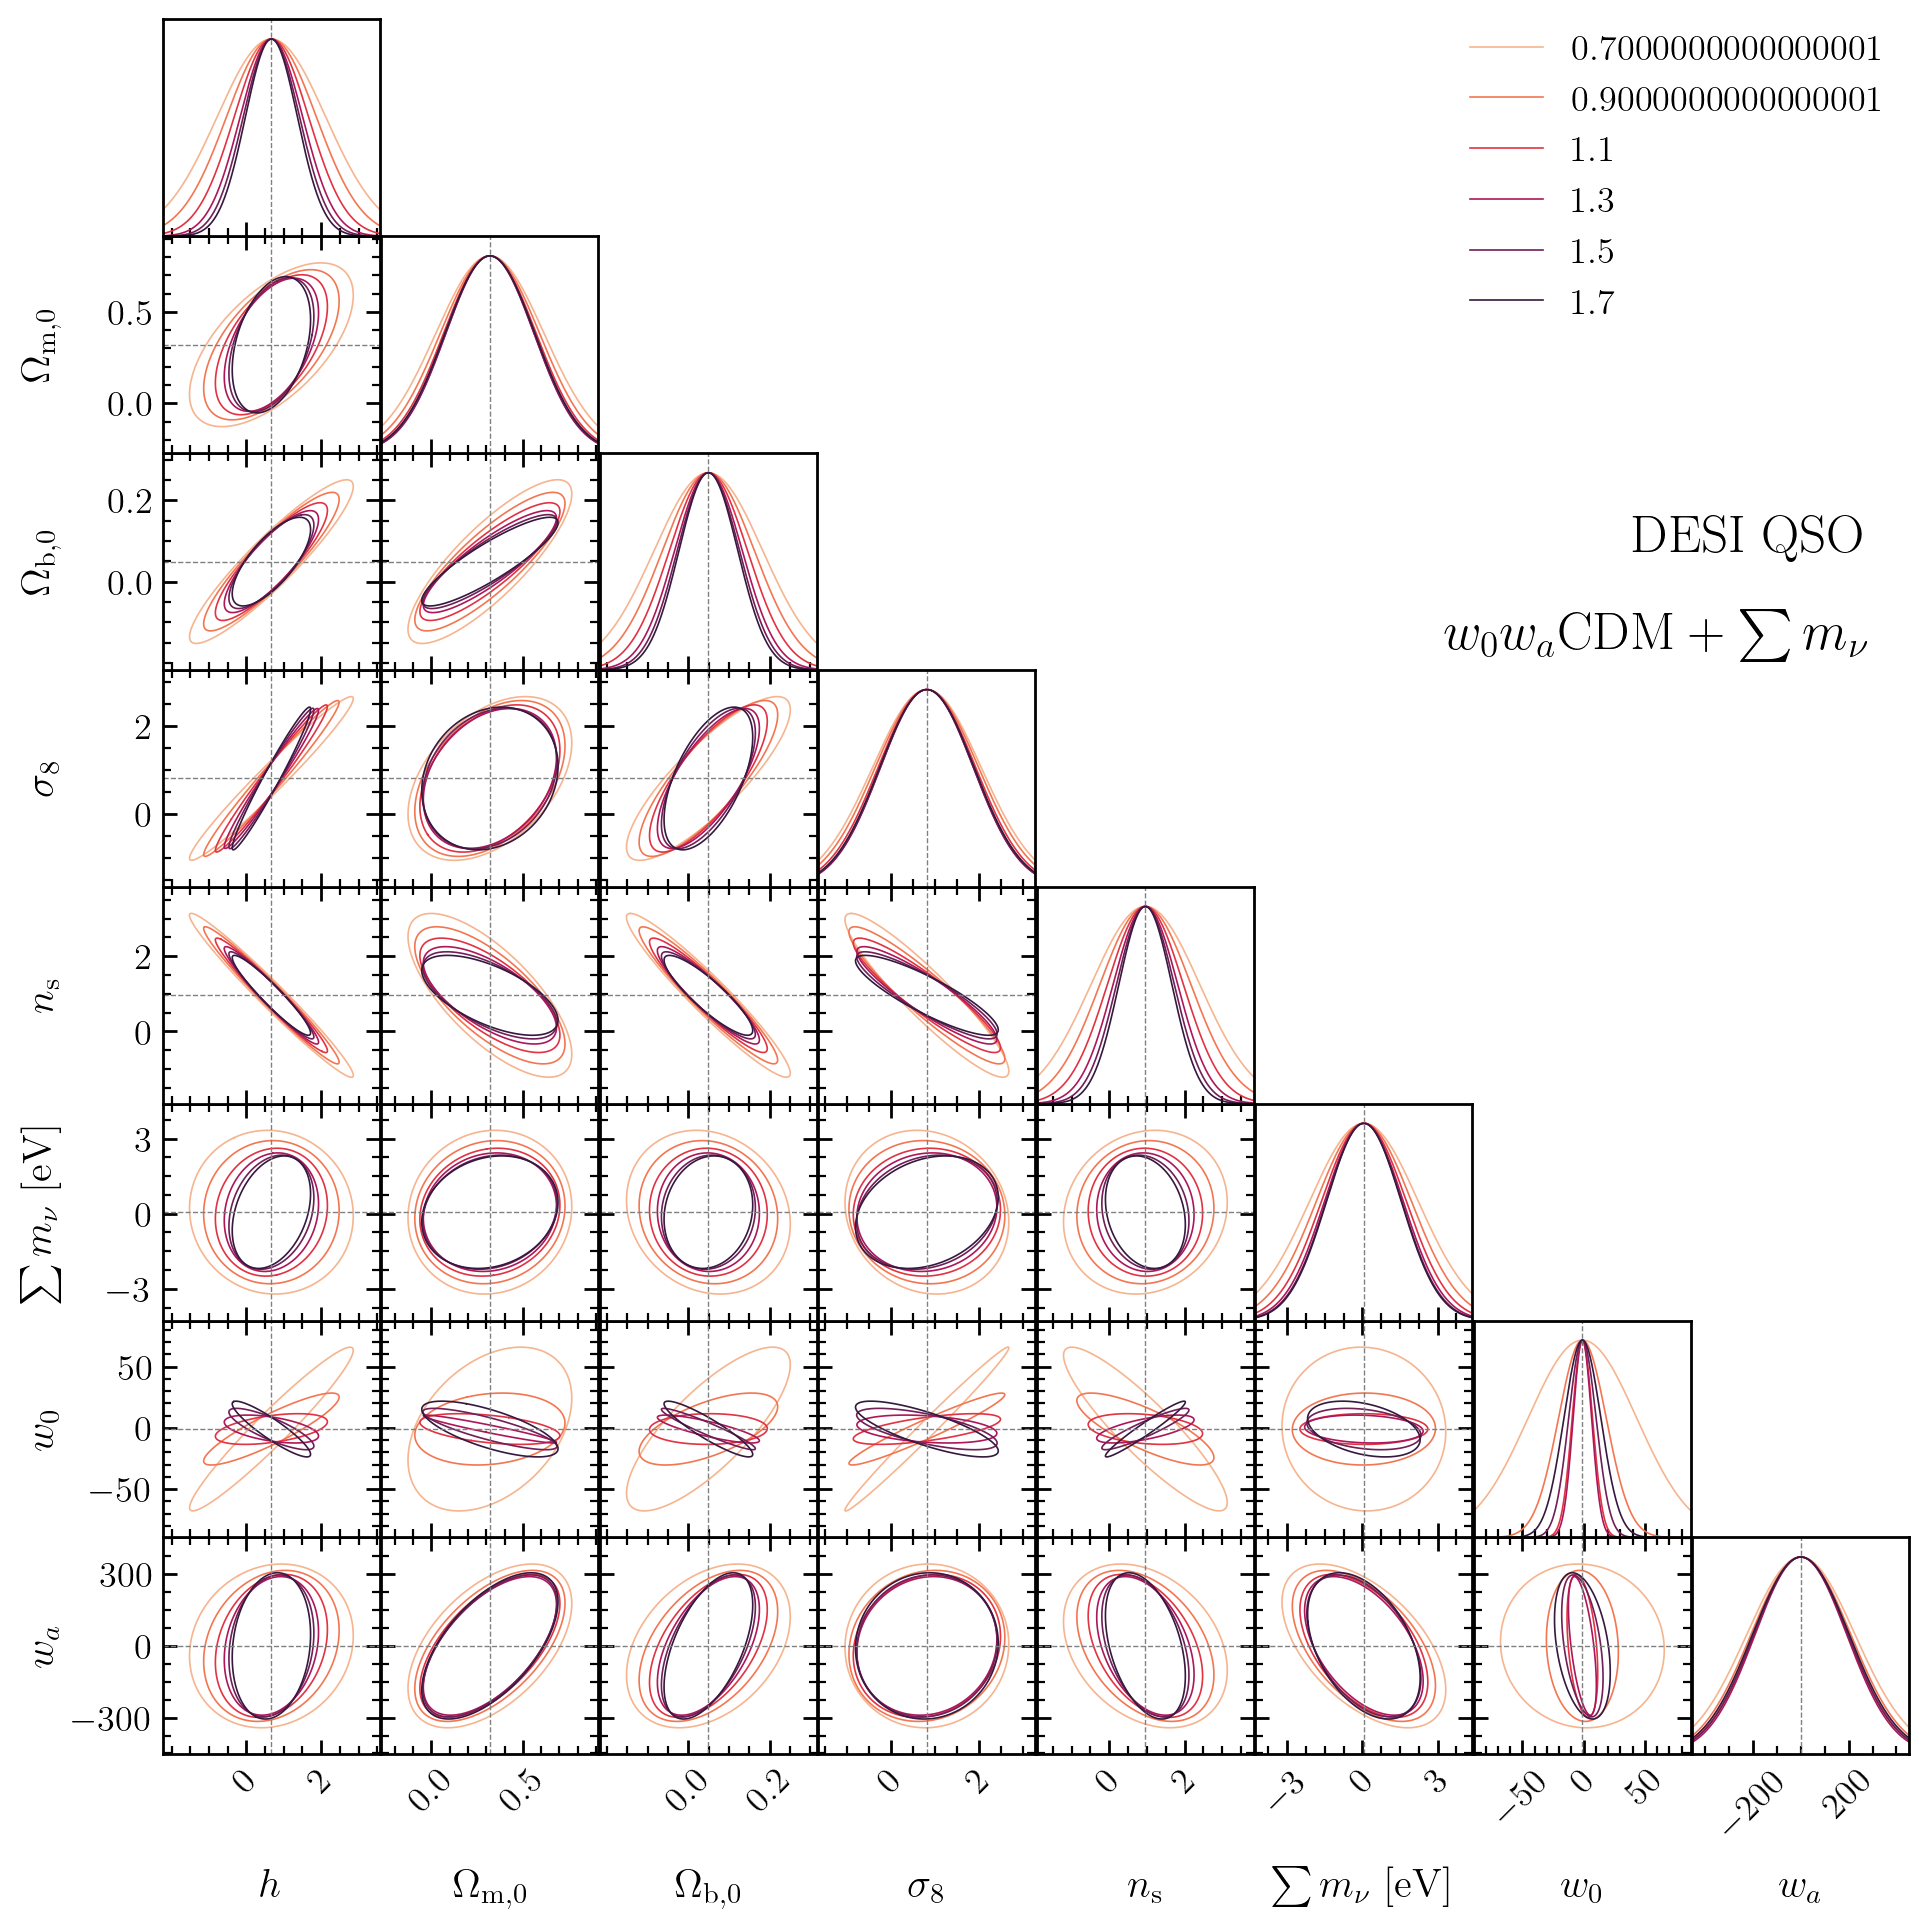

In [10]:
ploter.fig.set_dpi(200)
ploter.fig.align_labels()
for ax in ploter.fig.axes:
    ax.minorticks_on()
    ax.tick_params(which='major',length=5)
    ax.tick_params(which='minor',length=3)
y=len(orders)
axes=[]
start=0
for x in range(len(orders)):
    axes.append(ploter.fig.axes[start:start+y])
    start+=y
    y-=1
for col in axes:
    col[-1].yaxis.minorticks_off()
ploter.fig.text(0.95,0.70,'DESI QSO',horizontalalignment='right', verticalalignment='bottom')
ploter.fig.text(0.95,0.65,r'$w_0w_a\mathrm{CDM}+\sum m_\nu$',horizontalalignment='right', verticalalignment='bottom')
ploter.fig